# MQ4. PNEUMONIA

## AIFFEL Online Core 6기 최현우

### 1. Set-up

In [114]:
import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings(action='ignore')

In [115]:
# data load
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE
# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# 데이터 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
TRAIN_PATH = ROOT_PATH + '/chest_xray/data/train/*/*' # *은 모든 디렉토리와 파일을 의미합니다.
VAL_PATH = ROOT_PATH + '/chest_xray/data/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/data/test/*/*'

# 프로젝트를 진행할 때 아래 두 변수를 변경해보세요
BATCH_SIZE = 32
EPOCHS = 20

print(ROOT_PATH)

/aiffel/aiffel


### 2. Data-load

In [116]:
# data load 2
# data 별 num Check
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

5216
624
16


In [117]:
# val data 수량이 적어서 train과 분할
# train 데이터와 validation 데이터를 모두 filenames에 담습니다

filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# 모아진 filenames를 8:2로 나눕니다
train_size = math.floor(len(filenames)*0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print(len(train_filenames))
print(len(val_filenames))

4185
1047


In [118]:
# 정상, 폐렴 data dir (NORMAL, PNEUMONIA) 데이터 분할 해놓았음
print(f'Normal image path\n{filenames[0]}')
print(f'Pneumonia image path\n{filenames[2000]}')

Normal image path
/aiffel/aiffel/chest_xray/data/train/NORMAL/IM-0450-0001.jpeg
Pneumonia image path
/aiffel/aiffel/chest_xray/data/train/PNEUMONIA/person1345_bacteria_3422.jpeg


In [119]:
# 정상, 폐렴 경로대로 data num check
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")


COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

# 결과 Normal : 1093, Pneumonia : 3092
# train data imbalance

Normal images count in training set: 1070
Pneumonia images count in training set: 3115


In [120]:
# 데이터 파이프라인 만들기. train, val data tensor로 저장
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

In [121]:
# train, val dataset num Check
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

Training images count: 4185
Validating images count: 1047


In [122]:
# label data 만들기. 경로로 분할 되있으니 경로로 만들어주기
# os.path.sep : 파일 경로를 '/' 구분자로 분할
# data/train/PNEUMONIA/image_file 이라 [-2]로 구분
# 파일 경로의 끝에서 두번째 부분을 확인하면 양성과 음성을 구분할 수 있습니다

def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)

In [123]:
# 원본 데이터 Type Check
element_spec = train_list_ds.element_spec
print(element_spec)

TensorSpec(shape=(), dtype=tf.string, name=None)


In [124]:
## Data Augmentation
## 기존 회전에다가 추가 진행

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
    tf.keras.layers.experimental.preprocessing.RandomZoom(0.1)
])

In [125]:
# Resize image(decode) & Type Change (str > unit8 > float32 > resize)

def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

# 이미지 파일의 경로를 입력하면 이미지와 라벨을 읽어옵니다.
## Data augmentation 적용 추가

def process_path(file_path):
    label = get_label(file_path) # 라벨 검출
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    img = data_augmentation(img) # 데이터 증강 적용
    return img, label

In [126]:
# dataset 생성
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [127]:
# dataset shape 확인
data_element_spec = train_ds.element_spec
print(data_element_spec)
# 결과 shape(180,180,3) type=float32

(TensorSpec(shape=(180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.bool, name=None))


In [128]:
# image resize, label Check

for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  False


In [129]:
# test dataset 생성 & data num Check

test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


In [130]:
# data 변환
# shuffle(), repeat(), batch() 
# prefetch(): GPU에서 학습하는 동안 다음 데이터 CPU에서 준비하는 함수
# prefetch() 모르는 함수 (기억!)

def prepare_for_training(ds, shuffle_buffer_size=1000):
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

### 3. Data-visualization

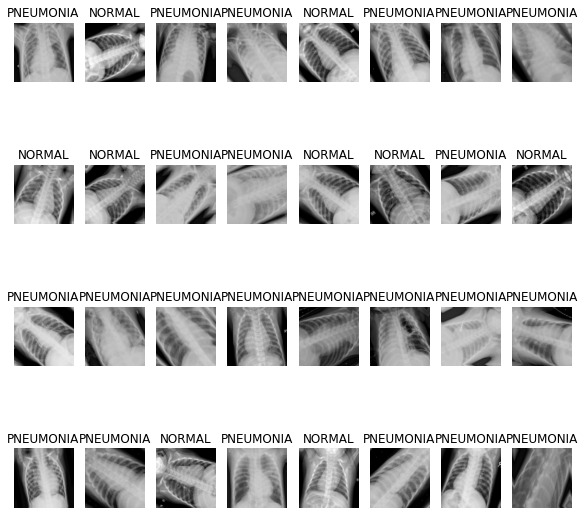

In [131]:
# data 시각화
# 첫 번째 배치 추출
# for문으로 정상/폐렴 분할

# 이미지 배치를 입력하면 여러장의 이미지를 보여줍니다.
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(4,math.ceil(BATCH_SIZE/4),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")


image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

### 4. ResNet Modeling (origin model : CNN Modeling)


In [132]:
# ResNet Modeling (risidual module)
## ResNet Skip_connection architecture, 참고 블로그 보니 identity 라고 하고 이미지에서 skip x를 identity라 함!
# 구조 : identity_block(skip connection), ReseNet_block
# 구조 : Conv layer 3개(64), 4개(128), 6개(256), 5개(512)
# 구조 : input 7x7(64)+ padding='same' + pooling, channel /2 pooling
# 구조 : 2개 Conv + identity(skip)
# 구조 : avg pool + FC(1000)

def identity_block(X, f, filters):
    X_shortcut = X

    # First component of main path & BottleNeck (1x1)
    X = tf.keras.layers.Conv2D(filters, kernel_size=1, strides=1, padding='valid')(X)
    X = tf.keras.layers.BatchNormalization(axis=3)(X)
    X = tf.keras.layers.Activation('relu')(X)

    # Second component of main path
    X = tf.keras.layers.Conv2D(filters, kernel_size=f, strides=1, padding='same')(X)
    X = tf.keras.layers.BatchNormalization(axis=3)(X)
    X = tf.keras.layers.Activation('relu')(X)
    
    # Third component of main path
    X = tf.keras.layers.Conv2D(filters, kernel_size=f, strides=1, padding='same')(X)
    X = tf.keras.layers.BatchNormalization(axis=3)(X)
    X = tf.keras.layers.Activation('relu')(X)

    # Final step: Add shortcut value to main path
    X = tf.keras.layers.Add()([X, X_shortcut])
    X = tf.keras.layers.Activation('relu')(X)

    return X

In [133]:
## ResNet Main_layers architecture

def ResNet18(input_shape=(180, 180, 3)):
    X_input = tf.keras.layers.Input(input_shape)

    # Initial conv layer
    X = tf.keras.layers.Conv2D(64, (7, 7), strides=(2, 2), padding='same')(X_input)
    X = tf.keras.layers.BatchNormalization(axis=3)(X)
    X = tf.keras.layers.Activation('relu')(X)
    X = tf.keras.layers.MaxPooling2D((2, 2), strides=(2, 2))(X)

    # Stage 1 (64 channels, 3 layers)
    X = identity_block(X, f=3, filters=64)
    X = identity_block(X, f=3, filters=64)
    X = identity_block(X, f=3, filters=64)
    X = tf.keras.layers.MaxPooling2D((2, 2), strides=(2, 2))(X)

    # Stage 2 (128 channels, 4 layers)
    X = identity_block(X, f=3, filters=128)
    X = identity_block(X, f=3, filters=128)
    X = identity_block(X, f=3, filters=128)
    X = identity_block(X, f=3, filters=128)
    X = tf.keras.layers.MaxPooling2D((2, 2), strides=(2, 2))(X)

    # Stage 3 (256 channels, 6 layers)
    X = identity_block(X, f=3, filters=256)
    X = identity_block(X, f=3, filters=256)
    X = identity_block(X, f=3, filters=256)
    X = identity_block(X, f=3, filters=256)
    X = identity_block(X, f=3, filters=256)
    X = identity_block(X, f=3, filters=256)
    X = tf.keras.layers.MaxPooling2D((2, 2), strides=(2, 2))(X)

    # Stage 4 (512 channels, 5 layers)
    X = identity_block(X, f=3, filters=512)
    X = identity_block(X, f=3, filters=512)
    X = identity_block(X, f=3, filters=512)
    X = identity_block(X, f=3, filters=512)
    X = identity_block(X, f=3, filters=512)
    X = tf.keras.layers.GlobalAveragePooling2D((2, 2), strides=None)(X)
    
    X = tf.keras.layers.Flatten()(X)
    X = tf.keras.layers.Dense(units=2, activation='sigmoid')(X)  # 예를 들어, CIFAR-10의 경우 10으로 설정

    return X_input, X

# Create model
input_shape = (180,180,3)
model = tf.keras.models.Model(input_shape, name='ResNet18')


### 5. Data-imbalace 처리
위에서 Pneumonia, Normal data 차이가 많이 납니다

In [134]:
# imbalance 처리
# Weight balaning technic 처음 봄(기억!)
# train data에서 특정 class에 큰 가중치를 주어서 balance 맞추는 기법
# 0 : 정상, 1: 폐렴

# 서로 클래스 건수에 반비례하게 설정하는 코드
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.96
Weight for PNEUMONIA: 0.67


### 6. Model-Fit

In [135]:
## callbacks: earlystopping, lr_schedule Setting

from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler

# Early Stopping Callback
early_stopping_callback = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# Learning Rate Scheduler
## epoch 5 step 마다 lr 절반씩 감소 (local feature 추출에서는 작은 학습률이 도움 된다고 들었음)
def learning_rate_scheduler(epoch, learning_rate):
    if epoch%5 == 0:
        return learning_rate * 0.5
    else:
        return learning_rate

lr_scheduler_callback = LearningRateScheduler(learning_rate_scheduler)


In [136]:
# GPU 사용 설정 : 코랩에서만 해서 처음 보는 코드 (기억!)
## learning_rate_scheduler 추가

with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.003),
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [137]:
# 파라미터들을 대입하고 모델 fit

with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
        callbacks=[early_stopping_callback, lr_scheduler_callback] 
        ## callbacks 추가
    )

Epoch 1/20
130/130 [==============================] - 80s 516ms/step - loss: 0.4707 - accuracy: 0.7519 - precision: 0.9336 - recall: 0.7175 - val_loss: 0.6225 - val_accuracy: 0.7324 - val_precision: 0.7324 - val_recall: 1.0000
Epoch 2/20
130/130 [==============================] - 66s 513ms/step - loss: 0.2999 - accuracy: 0.8849 - precision: 0.9658 - recall: 0.8762 - val_loss: 0.9549 - val_accuracy: 0.7324 - val_precision: 0.7324 - val_recall: 1.0000
Epoch 3/20
130/130 [==============================] - 67s 519ms/step - loss: 0.2704 - accuracy: 0.8942 - precision: 0.9629 - recall: 0.8929 - val_loss: 1.2933 - val_accuracy: 0.7383 - val_precision: 0.7383 - val_recall: 1.0000
Epoch 4/20
130/130 [==============================] - 68s 528ms/step - loss: 0.2416 - accuracy: 0.9029 - precision: 0.9716 - recall: 0.8957 - val_loss: 1.4988 - val_accuracy: 0.7295 - val_precision: 0.7295 - val_recall: 1.0000
Epoch 5/20
130/130 [==============================] - 72s 553ms/step - loss: 0.2264 - accura

### 7. 결과 확인

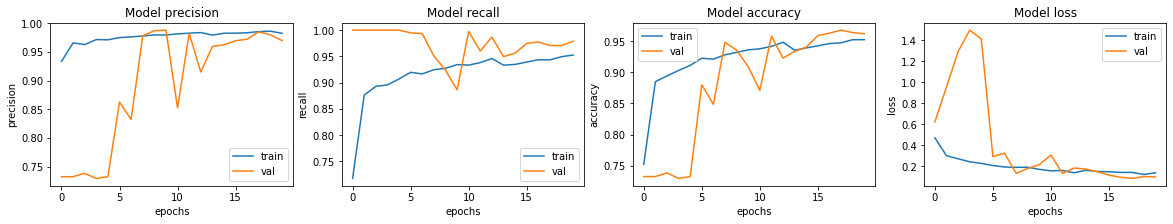

In [138]:
# 시각화 precision, recall, acc, loss

fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [139]:
# test output
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

20/20 [==============================] - 6s 306ms/step - loss: 0.5794 - accuracy: 0.7965 - precision: 0.7553 - recall: 0.9974
Loss: 0.5794280767440796,
Accuracy: 0.7964743375778198,
Precision: 0.7553398013114929,
Recall: 0.9974358677864075
